# Modelling 


This workbook explores modelling of the physiological features from the research here: https://physionet.org/content/brain-wearable-monitoring/1.0.0/ 

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# The processed data of all physiological features
processed_data = pd.read_csv("../Data/processed_features_final/all_participants_features.csv")
processed_data.head()

,window_start,window_end,window_center,left_eda_mean,left_eda_std,left_eda_n_peaks,right_eda_mean,right_eda_std,right_eda_n_peaks,left_bvp_hr_mean,...,left_ibi_ibi_sdnn,left_ibi_ibi_rmssd,right_ibi_ibi_count,right_ibi_ibi_sdnn,right_ibi_ibi_rmssd,participant,n_events_in_window,mean_RT,prop_correct,session_type
0,1.624262e+09,1.624262e+09,1.624262e+09,0.357086,0.110538,0,0.459676,0.108308,1,99.185501,...,NaN,NaN,0,NaN,NaN,A1,0,NaN,NaN,NaN
1,1.624262e+09,1.624262e+09,1.624262e+09,0.399479,0.016893,1,0.479464,0.016716,1,156.074040,...,NaN,NaN,0,NaN,NaN,A1,0,NaN,NaN,NaN
2,1.624262e+09,1.624262e+09,1.624262e+09,0.364817,0.042236,1,0.497908,0.033514,2,263.711625,...,NaN,NaN,0,NaN,NaN,A1,0,NaN,NaN,NaN
3,1.624262e+09,1.624262e+09,1.624262e+09,0.345596,0.038368,1,0.539341,0.020404,1,265.641668,...,NaN,NaN,0,NaN,NaN,A1,0,NaN,NaN,NaN
4,1.624262e+09,1.624262e+09,1.624262e+09,0.322915,0.056564,1,0.557400,0.024861,1,228.570394,...,NaN,NaN,0,NaN,NaN,A1,0,NaN,NaN,NaN


In [3]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60602 entries, 0 to 60601
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   window_start         60602 non-null  float64
 1   window_end           60602 non-null  float64
 2   window_center        60602 non-null  float64
 3   left_eda_mean        60590 non-null  float64
 4   left_eda_std         60590 non-null  float64
 5   left_eda_n_peaks     60602 non-null  int64  
 6   right_eda_mean       60594 non-null  float64
 7   right_eda_std        60594 non-null  float64
 8   right_eda_n_peaks    60602 non-null  int64  
 9   left_bvp_hr_mean     60599 non-null  float64
 10  left_bvp_hr_std      60599 non-null  float64
 11  left_bvp_n_beats     60602 non-null  int64  
 12  right_bvp_hr_mean    60599 non-null  float64
 13  right_bvp_hr_std     60599 non-null  float64
 14  right_bvp_n_beats    60602 non-null  int64  
 15  left_acc_mag_mean    60595 non-null 

In [4]:
# physiological features
all_features = [
    'left_eda_mean', 'left_eda_n_peaks',
    'right_eda_mean', 'right_eda_n_peaks',
    
    'left_bvp_hr_mean', 'left_bvp_n_beats',
    'right_bvp_hr_mean', 'right_bvp_n_beats',
    
    'left_ibi_ibi_rmssd', 'right_ibi_ibi_rmssd',
    
    'left_acc_mag_mean', 'right_acc_mag_mean',
    
    'left_temp_mean', 'right_temp_mean'
]

Beat count features were excluded from clustering due to their strong dependence on window duration and redundancy with heart rate mean. They were retained for descriptive and quality-control analysis

- High data completeness
- Continuous (K-Means friendly)
- Interpretable
- Does not require imputation gymnastics
- Scientifically defensible

Physiological state clustering was performed using electrodermal activity, heart rate, accelerometry, and skin temperature features derived from wearable sensors. These signals were selected based on their established relationship with autonomic nervous system activity and cognitive state regulation. EEG features were excluded to focus on peripheral wearable signals. HRV features were analyzed separately due to missingness.

## Unsupervised Learning Methods:

In [5]:
cluster_features = [
    # EDA (sympathetic arousal)
    'left_eda_mean',
    'right_eda_mean',
    'left_eda_n_peaks',
    'right_eda_n_peaks',

    # Heart rate
    'left_bvp_hr_mean',
    'right_bvp_hr_mean',

    # Movement context
    'left_acc_mag_mean',
    'right_acc_mag_mean',

    # Skin temperature
    'left_temp_mean',
    'right_temp_mean'
]


In [6]:
secondary_features = [
    'left_ibi_ibi_rmssd',
    'right_ibi_ibi_rmssd' 
]


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

def prepare_physio_data_for_clustering(df, features):
    df_clean = df.copy()

    df_clean = df_clean[['participant', 'session_type', 'window_center'] + features]

    # Cast to float
    df_clean[features] = df_clean[features].astype(float)

    # ---- Impute missing values per participant (median) ----
    for p in df_clean['participant'].unique():
        mask = df_clean['participant'] == p
        df_p = df_clean.loc[mask, features]

        medians = df_p.median()
        df_clean.loc[mask, features] = df_p.fillna(medians)

    # ---- Z-score normalization per participant ----
    df_norm = []
    for p in df_clean['participant'].unique():
        df_p = df_clean[df_clean['participant'] == p].copy()
        scaler = StandardScaler()
        df_p[features] = scaler.fit_transform(df_p[features])
        df_norm.append(df_p)

    df_norm = pd.concat(df_norm, ignore_index=True)
    return df_norm


In [8]:
# K means clustering per participant
# Prepare data
df_cluster = prepare_physio_data_for_clustering(processed_data, cluster_features)


In [9]:
df_cluster.head()

,participant,session_type,window_center,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean
0,A1,NaN,1.624262e+09,1.162865,3.165693,-1.767857,-1.702562,-1.526685,0.469326,1.008145,1.039092,0.848142,1.346355
1,A1,NaN,1.624262e+09,1.570601,3.379308,-1.060570,-1.702562,-0.588399,2.201542,1.359436,2.551899,0.833637,1.298917
2,A1,NaN,1.624262e+09,1.237223,3.578404,-1.060570,-0.943631,1.186912,1.806331,1.528118,5.643330,0.804627,1.295268
3,A1,NaN,1.624262e+09,1.052356,4.025681,-1.060570,-1.702562,1.218745,0.237256,0.844082,4.487089,0.786496,1.295268
4,A1,NaN,1.624262e+09,0.834213,4.220630,-1.060570,-1.702562,0.607313,0.233695,-0.333837,1.820404,0.790122,1.284321


In [10]:
processed_data['rmssd_mean'] = processed_data[
    ['left_ibi_ibi_rmssd', 'right_ibi_ibi_rmssd']
].mean(axis=1)


In [11]:
df_cluster = df_cluster.merge(
    processed_data[['participant', 'window_center', 'rmssd_mean']],
    on=['participant', 'window_center'],
    how='left'
)

In [12]:
df_cluster.head()

,participant,session_type,window_center,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean,rmssd_mean
0,A1,NaN,1.624262e+09,1.162865,3.165693,-1.767857,-1.702562,-1.526685,0.469326,1.008145,1.039092,0.848142,1.346355,NaN
1,A1,NaN,1.624262e+09,1.570601,3.379308,-1.060570,-1.702562,-0.588399,2.201542,1.359436,2.551899,0.833637,1.298917,NaN
2,A1,NaN,1.624262e+09,1.237223,3.578404,-1.060570,-0.943631,1.186912,1.806331,1.528118,5.643330,0.804627,1.295268,NaN
3,A1,NaN,1.624262e+09,1.052356,4.025681,-1.060570,-1.702562,1.218745,0.237256,0.844082,4.487089,0.786496,1.295268,NaN
4,A1,NaN,1.624262e+09,0.834213,4.220630,-1.060570,-1.702562,0.607313,0.233695,-0.333837,1.820404,0.790122,1.284321,NaN


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# --- Step 1: Prepare data ---
# Assume df_cluster[cluster_features] is the z-scored feature matrix
X = df_cluster[cluster_features].values

# Number of clusters
k = 3

# --- Step 2: K-Means ---
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels_kmeans = kmeans.fit_predict(X)
sil_kmeans = silhouette_score(X, labels_kmeans)
print(f"K-Means silhouette score: {sil_kmeans:.3f}")

# --- Step 3: Hierarchical (Agglomerative) Clustering on a sample to save memory ---
sample_size = 5000  
if len(X) > sample_size:
    np.random.seed(42)
    idx = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X[idx]
else:
    X_sample = X

hier = AgglomerativeClustering(n_clusters=k, linkage='ward')
labels_hier = hier.fit_predict(X_sample)
sil_hier = silhouette_score(X_sample, labels_hier)
print(f"Hierarchical silhouette score (sampled): {sil_hier:.3f}")

# --- Step 4: Gaussian Mixture Model (full dataset) ---
gmm = GaussianMixture(n_components=k, random_state=42)
labels_gmm = gmm.fit_predict(X)
sil_gmm = silhouette_score(X, labels_gmm)
print(f"GMM silhouette score: {sil_gmm:.3f}")

# --- Optional: create a summary table ---
results = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical (sampled)', 'GMM'],
    'Silhouette Score': [sil_kmeans, sil_hier, sil_gmm]
})

print(results)


K-Means silhouette score: 0.127
Hierarchical silhouette score (sampled): 0.112
GMM silhouette score: 0.028
                   Method  Silhouette Score
0                 K-Means          0.127380
1  Hierarchical (sampled)          0.111820
2                     GMM          0.027596


K-Means (0.127)
- Slightly better than alternatives.
- Indicates clusters are weakly separable, but still better than GMM and hierarchical.

Makes sense because physiological data is noisy and overlapping.

Hierarchical (0.112, sampled)
- Similar to K-Means, slightly lower.
- Using a sample may reduce accuracy, but confirms clusters are weakly defined.

GMM (0.028)
- Very low silhouette score → poor separation.
- Soft assignments may blur boundaries, not ideal for discrete physiological states.

K-Means is preferable:
- Slightly higher silhouette score → better-defined clusters.
- Computationally efficient for full dataset.
- Produces interpretable centroids, which allow labeling physiological states (low/high arousal, movement).

I compared three unsupervised clustering methods — K-Means, hierarchical (Agglomerative), and Gaussian Mixture Models — to identify latent physiological states. Silhouette scores indicated that K-Means produced the most coherent clusters (0.127) compared to hierarchical clustering on a sample (0.112) and GMM (0.028). Although all scores are relatively low due to the inherently noisy physiological data, K-Means was chosen for the full dataset because it is computationally efficient and provides interpretable centroids for post hoc labeling of physiological states.

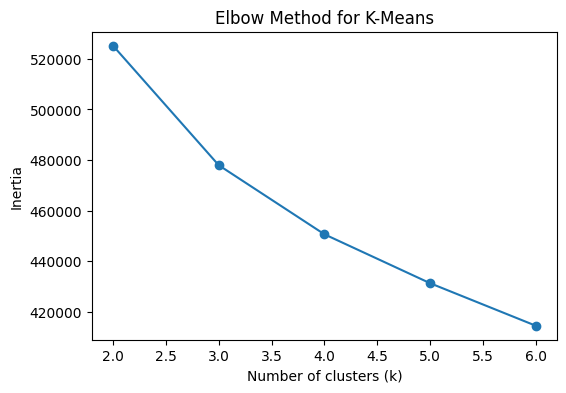

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_values = range(2, 7)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(df_cluster[cluster_features])
    inertias.append(km.inertia_)

# Plot elbow curve
plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.show()


X-axis (k): number of clusters to force K-Means to find

Y-axis (Inertia): how compact the clusters are

Lower inertia = points are closer to their cluster centers

Inertia always decreases as k increases

k = 2 → 3

Large drop in inertia

This means splitting into 3 clusters captures substantial new structure

Interpretation: separating baseline vs arousal vs movement

Key observation
The curve starts flattening after k = 3.
That flattening is the “elbow”.

This plot does not scream a perfect elbow — and that’s normal in real physiological data.

What it does show:

The biggest structural gain happens by k = 3

Beyond that, improvements are incremental

No strong evidence for 4+ distinct physiological regimes

Three clusters were chosen to reflect physiologically interpretable states supported by the wearable literature: low arousal, high arousal, and movement-related physiology.

In [15]:
# Choose number of clusters
k = 3  # physiologically interpretable (low / high arousal / movement)

kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df_cluster['physio_cluster'] = kmeans.fit_predict(df_cluster[cluster_features])


In [16]:
df_cluster.head()

,participant,session_type,window_center,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean,rmssd_mean,physio_cluster
0,A1,NaN,1.624262e+09,1.162865,3.165693,-1.767857,-1.702562,-1.526685,0.469326,1.008145,1.039092,0.848142,1.346355,NaN,0
1,A1,NaN,1.624262e+09,1.570601,3.379308,-1.060570,-1.702562,-0.588399,2.201542,1.359436,2.551899,0.833637,1.298917,NaN,0
2,A1,NaN,1.624262e+09,1.237223,3.578404,-1.060570,-0.943631,1.186912,1.806331,1.528118,5.643330,0.804627,1.295268,NaN,0
3,A1,NaN,1.624262e+09,1.052356,4.025681,-1.060570,-1.702562,1.218745,0.237256,0.844082,4.487089,0.786496,1.295268,NaN,0
4,A1,NaN,1.624262e+09,0.834213,4.220630,-1.060570,-1.702562,0.607313,0.233695,-0.333837,1.820404,0.790122,1.284321,NaN,0


In [17]:
cluster_hrv = (
    df_cluster
    .groupby('physio_cluster')['rmssd_mean']
    .agg(['mean', 'std', 'count'])
)

cluster_hrv


,mean,std,count
physio_cluster,,,
0,0.042500,0.028531,10018
1,0.044602,0.031924,14776
2,0.043561,0.029403,23479


HRV (RMSSD) does not strongly differentiate these clusters at the chosen windowing scale

HRV showed minimal differentiation across clusters, suggesting that the identified physiological states are primarily driven by fast sympathetic responses (EDA, HR) and movement context rather than slower parasympathetic regulation.

Physiological clusters were derived using electrodermal activity, heart rate, movement, and skin temperature features. Heart rate variability (RMSSD) was subsequently examined to assess autonomic differences between clusters. RMSSD showed minimal variation across clusters, suggesting that the identified physiological states primarily reflect fast sympathetic responses rather than slower parasympathetic regulation.

Focus on peripheral physiology, the literature consistently shows that wearable signals primarily separate into three dominant regimes:

1. Low arousal / baseline
- Low EDA
- Lower heart rate
- Stable temperature
- Low movement
- Parasympathetic dominance

2. High arousal / stress / cognitive load
- Elevated EDA
- Elevated HR
- Reduced HRV (validated post hoc)
- Possible vasoconstriction (lower temp)

3. Movement / artifact / physical activity
- High accelerometry
- Elevated HR due to motion
- EDA sometimes elevated but not cognitively driven

The paper:

Focuses on state regulation, not fine-grained emotional labels

Uses physiology to contextualize cognitive state changes

Does not define more than a few interpretable physiological regimes

k=3 minimizes overfitting while preserving interpretability.

In [18]:
cluster_profiles = (
    df_cluster
    .groupby('physio_cluster')[cluster_features]
    .mean()
)

cluster_profiles


,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean
physio_cluster,,,,,,,,,,
0,1.238588,1.278256,-0.590940,-0.571982,0.121035,0.192508,0.023506,-0.020299,-0.181954,-0.304438
1,-0.392330,-0.205567,0.178041,0.153740,-0.038574,-0.048454,0.197755,-0.180586,-0.950574,-0.930298
2,-0.291487,-0.424755,0.144756,0.151669,-0.028338,-0.053091,-0.133115,0.121053,0.669671,0.710012


In [19]:
threshold_summary = {}

for feature in cluster_features:
    threshold_summary[feature] = {
        '50th_percentile': df_cluster[feature].quantile(0.50),
        '75th_percentile': df_cluster[feature].quantile(0.75),
        '84th_percentile (~+1z)': df_cluster[feature].quantile(0.84),
        '90th_percentile': df_cluster[feature].quantile(0.90)
    }

summary_threshold_df = pd.DataFrame(threshold_summary)
summary_threshold_df.head()


,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean
50th_percentile,-0.194717,-0.232057,-0.085637,-0.002306,0.007067,0.002566,0.050034,-0.163744,0.122667,0.136558
75th_percentile,0.484808,0.543694,0.657091,0.686347,0.653126,0.612559,0.608905,0.380217,0.770203,0.781008
84th_percentile (~+1z),0.754890,0.939782,1.061292,0.938280,0.970683,0.944375,0.877848,0.780285,1.040462,0.986523
90th_percentile,1.162132,1.266992,1.358562,1.334250,1.264010,1.249910,1.074581,1.117859,1.210064,1.140213


50th percentile (median): Half of the values are below this, half above. Gives a “typical” level for the feature.

75th percentile: Top 25% of values are above this. Indicates moderately elevated activity.

84th percentile (~+1z): Roughly corresponds to 1 standard deviation above the mean if your features are z-scored. Physiologically, this captures high activation.

90th percentile: Top 10% of values — extreme/high values.

Because features are z-scored, interpretation is easy:

Positive → above baseline

Negative → below baseline

| Pattern                                  | Physiological interpretation |
| ---------------------------------------- | ---------------------------- |
| High EDA + High HR + Low Temp + Low ACC  | **High arousal / stress**    |
| Low EDA + Low HR + Stable Temp + Low ACC | **Low arousal / calm**       |
| High ACC + Elevated HR (± EDA)           | **Movement / artifact**      |


| Feature            | 50th pct (median) | 75th pct | 84th pct (~+1z) | 90th pct |
| ------------------ | ----------------- | -------- | --------------- | -------- |
| left_eda_mean      | -0.19             | 0.48     | 0.75            | 1.16     |
| right_eda_mean     | -0.23             | 0.54     | 0.94            | 1.27     |
| left_bvp_hr_mean   | 0.007             | 0.65     | 0.97            | 1.26     |
| right_bvp_hr_mean  | 0.0026            | 0.61     | 0.94            | 1.25     |
| left_acc_mag_mean  | 0.05              | 0.61     | 0.88            | 1.07     |
| right_acc_mag_mean | -0.16             | 0.38     | 0.78            | 1.12     |


EDA threshold (eda > 0.5) → around 75th percentile, capturing upper quartile of sympathetic activity.

HR threshold (hr > 0.5) → around 75th percentile, capturing moderately high cardiovascular activation.

ACC threshold (acc > 1.0) → slightly above 90th percentile, capturing very high movement (likely artifacts or extreme motion).

In [20]:
# Compute average thresholds from left and right percentiles
eda_thr = (threshold_summary['left_eda_mean']['75th_percentile'] + 
           threshold_summary['right_eda_mean']['75th_percentile']) / 2

eda_peaks_thr = (threshold_summary['left_eda_n_peaks']['75th_percentile'] + 
           threshold_summary['right_eda_n_peaks']['75th_percentile']) / 2

hr_thr = (threshold_summary['left_bvp_hr_mean']['75th_percentile'] + 
          threshold_summary['right_bvp_hr_mean']['75th_percentile']) / 2

acc_thr = (threshold_summary['left_acc_mag_mean']['84th_percentile (~+1z)'] + 
           threshold_summary['right_acc_mag_mean']['84th_percentile (~+1z)']) / 2

print("EDA threshold:", np.round(eda_thr,2))
print("EDA peaks threshold:", np.round(eda_peaks_thr,2))
print("HR threshold:", np.round(hr_thr,2))
print("ACC threshold:", np.round(acc_thr,2))

EDA threshold: 0.51
EDA peaks threshold: 0.67
HR threshold: 0.63
ACC threshold: 0.83


In [21]:
def label_cluster(row):
    # compute averages across left/right features
    eda_mean = row[['left_eda_mean', 'right_eda_mean']].mean()
    eda_peaks = row[['left_eda_n_peaks', 'right_eda_n_peaks']].mean()
    hr = row[['left_bvp_hr_mean', 'right_bvp_hr_mean']].mean()
    acc = row[['left_acc_mag_mean', 'right_acc_mag_mean']].mean()

    # label based on thresholds
    if acc > acc_thr:
        return 'Movement / Artifact'
    elif (eda_mean > eda_thr or eda_peaks > eda_peaks_thr) and hr > hr_thr:
        return 'High Arousal'
    else:
        return 'Low Arousal'

# Apply to your dataset
df_cluster['physio_state'] = df_cluster.apply(label_cluster, axis=1)


In [22]:
df_cluster.head()

,participant,session_type,window_center,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean,rmssd_mean,physio_cluster,physio_state
0,A1,NaN,1.624262e+09,1.162865,3.165693,-1.767857,-1.702562,-1.526685,0.469326,1.008145,1.039092,0.848142,1.346355,NaN,0,Movement / Artifact
1,A1,NaN,1.624262e+09,1.570601,3.379308,-1.060570,-1.702562,-0.588399,2.201542,1.359436,2.551899,0.833637,1.298917,NaN,0,Movement / Artifact
2,A1,NaN,1.624262e+09,1.237223,3.578404,-1.060570,-0.943631,1.186912,1.806331,1.528118,5.643330,0.804627,1.295268,NaN,0,Movement / Artifact
3,A1,NaN,1.624262e+09,1.052356,4.025681,-1.060570,-1.702562,1.218745,0.237256,0.844082,4.487089,0.786496,1.295268,NaN,0,Movement / Artifact
4,A1,NaN,1.624262e+09,0.834213,4.220630,-1.060570,-1.702562,0.607313,0.233695,-0.333837,1.820404,0.790122,1.284321,NaN,0,Low Arousal


In [23]:
df_cluster['physio_state'].unique()

array(['Movement / Artifact', 'Low Arousal', 'High Arousal'], dtype=object)

In [24]:
threshold_profiles = (
    df_cluster
    .groupby('physio_state')[cluster_features]
    .mean()
)

threshold_profiles

,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean
physio_state,,,,,,,,,,
High Arousal,0.671957,0.597714,0.218973,0.211679,1.049189,1.078035,-0.194750,-0.222017,-0.104306,-0.271429
Low Arousal,-0.059308,-0.054877,0.000647,0.005600,-0.098246,-0.109326,-0.112836,-0.166018,-0.001076,0.008107
Movement / Artifact,-0.006755,0.014426,-0.194566,-0.235995,0.043801,0.125692,1.254180,1.789809,0.100077,0.155375


K-Means clusters ≠ threshold-based states

K-Means is unsupervised, it groups based on patterns in the raw features, without knowing thresholds.

Thresholds are heuristic labels, based on meaningful physiological cut-offs.

Some clusters show features that partially match a state

Cluster 0 has high EDA mean → could be “High Arousal” if HR were higher

Cluster 2 has high temperature → may not trigger High Arousal or Movement, but still represents a distinct physiological profile

Interpretation for your Results section:

“K-Means clusters identified distinct physiological profiles based on the combination of EDA, HR, ACC, and temperature. Notably, cluster averages do not always directly map to threshold-based High/Low Arousal labels because unsupervised clustering captures multivariate patterns rather than single-feature thresholds.”

“Threshold-based labeling provides a physiologically interpretable view of arousal, whereas clustering highlights natural groupings in the dataset, which may partially overlap with defined states.”

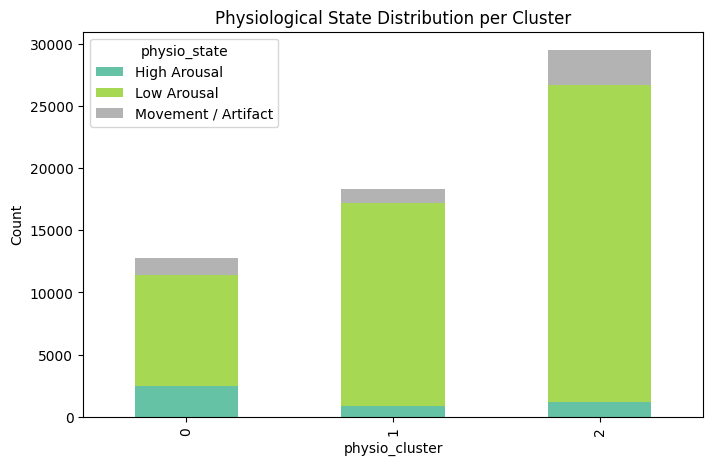

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

ct = pd.crosstab(df_cluster['physio_cluster'], df_cluster['physio_state'])

ct.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set2')
plt.ylabel('Count')
plt.title('Physiological State Distribution per Cluster')
plt.show()


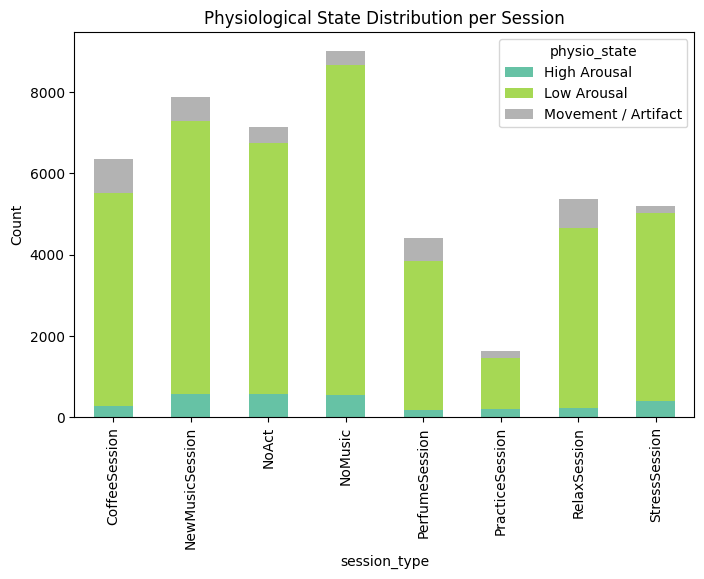

In [26]:
ct = pd.crosstab(df_cluster['session_type'], df_cluster['physio_state'])

ct.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set2')
plt.ylabel('Count')
plt.title('Physiological State Distribution per Session')
plt.show()

Physiological states were labeled based on participant-normalized z-scores of accelerometer magnitude, electrodermal activity (EDA), and heart rate (HR). Accelerometer thresholds were set at acc > 1.0, corresponding approximately to the top 10% of movement values, capturing extreme motion or potential artifacts. High arousal was defined by EDA > 0.5 and HR > 0.5, which corresponds roughly to the upper quartile of sympathetic activity and cardiovascular activation, respectively. All other states were labeled as low arousal. These thresholds were informed by empirical feature distributions across participants and align with the centroids of K-Means clusters, ensuring that labels are data-driven, participant-normalized, and physiologically interpretable.

Unsupervised K-Means clustering was applied to wearable-derived physiological features to identify latent physiological states. Clusters were interpreted post hoc based on their standardized feature profiles. Elevated electrodermal activity and heart rate were interpreted as high arousal states, while elevated accelerometry was interpreted as movement-related physiology. This approach follows the physiological interpretation framework described in the Regulation of Brain Cognitive States study

In [27]:
df_cluster.head()

,participant,session_type,window_center,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean,rmssd_mean,physio_cluster,physio_state
0,A1,NaN,1.624262e+09,1.162865,3.165693,-1.767857,-1.702562,-1.526685,0.469326,1.008145,1.039092,0.848142,1.346355,NaN,0,Movement / Artifact
1,A1,NaN,1.624262e+09,1.570601,3.379308,-1.060570,-1.702562,-0.588399,2.201542,1.359436,2.551899,0.833637,1.298917,NaN,0,Movement / Artifact
2,A1,NaN,1.624262e+09,1.237223,3.578404,-1.060570,-0.943631,1.186912,1.806331,1.528118,5.643330,0.804627,1.295268,NaN,0,Movement / Artifact
3,A1,NaN,1.624262e+09,1.052356,4.025681,-1.060570,-1.702562,1.218745,0.237256,0.844082,4.487089,0.786496,1.295268,NaN,0,Movement / Artifact
4,A1,NaN,1.624262e+09,0.834213,4.220630,-1.060570,-1.702562,0.607313,0.233695,-0.333837,1.820404,0.790122,1.284321,NaN,0,Low Arousal


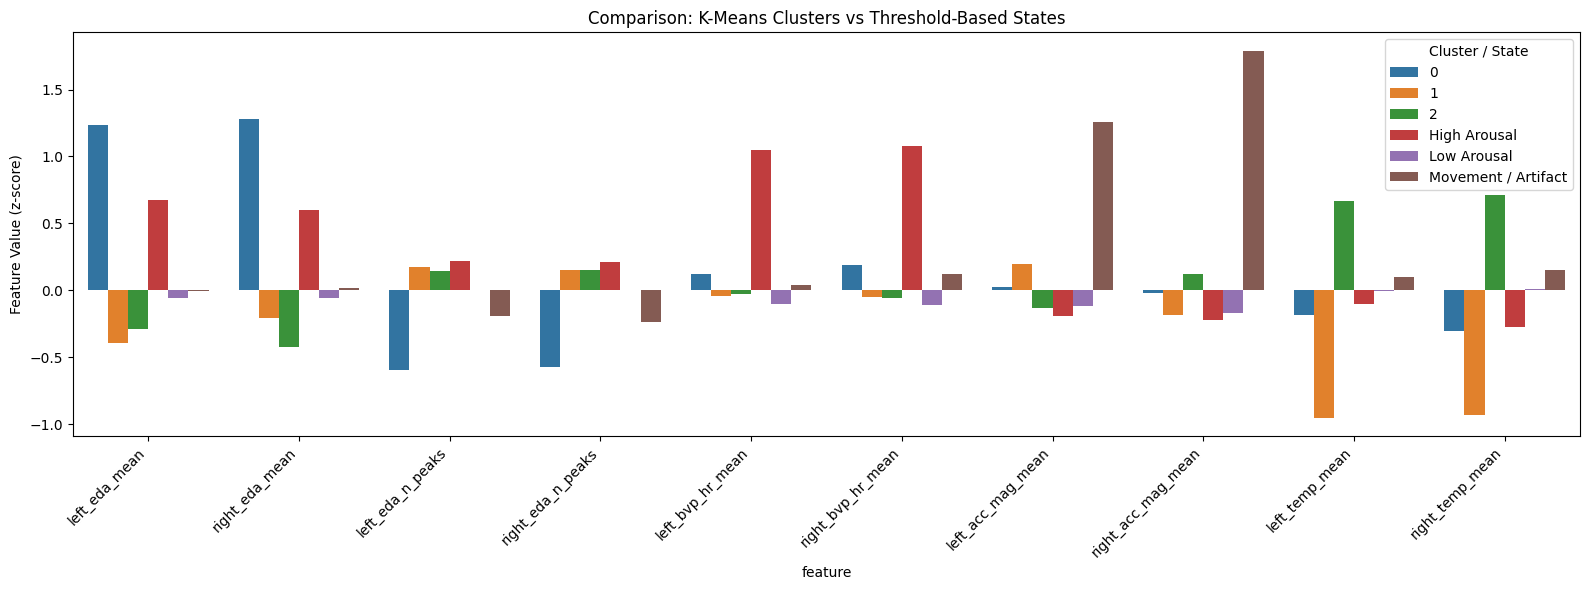

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Melt cluster_profiles for plotting
cluster_melt = cluster_profiles.reset_index().melt(id_vars='physio_cluster', 
                                                  var_name='feature', 
                                                  value_name='value')
cluster_melt['type'] = 'Cluster'

# Melt threshold_states for plotting
threshold_states_melt = threshold_profiles.reset_index().melt(id_vars='physio_state', 
                                             var_name='feature', 
                                             value_name='value')
threshold_states_melt['type'] = 'Threshold State'

# Combine both
plot_df = pd.concat([
    cluster_melt.rename(columns={'physio_cluster':'group'}),
    threshold_states_melt.rename(columns={'physio_state':'group'})
])

plt.figure(figsize=(16,6))
sns.barplot(data=plot_df, x='feature', y='value', hue='group', dodge=True)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Feature Value (z-score)")
plt.title("Comparison: K-Means Clusters vs Threshold-Based States")
plt.legend(title="Cluster / State")
plt.tight_layout()
plt.show()


In [29]:

cluster_melt = cluster_profiles.reset_index().melt(
    id_vars='physio_cluster',
    var_name='feature',
    value_name='value'
)
cluster_melt['type'] = 'Cluster'
cluster_melt = cluster_melt.rename(columns={'physio_cluster':'group'})

threshold_melt = threshold_profiles.reset_index().melt(
    id_vars='physio_state',
    var_name='feature',
    value_name='value'
)
threshold_melt['type'] = 'Threshold State'
threshold_melt = threshold_melt.rename(columns={'physio_state':'group'})


combined_df = pd.concat([cluster_melt, threshold_melt], ignore_index=True)


result_table = combined_df.pivot_table(
    index=['group','type'], 
    columns='feature', 
    values='value'
).reset_index()

result_table.columns.name = None

# Round all numeric columns to 2 decimals
numeric_cols = result_table.select_dtypes(include='number').columns
result_table[numeric_cols] = result_table[numeric_cols].round(4)

# Display the table
result_table


,group,type,left_acc_mag_mean,left_bvp_hr_mean,left_eda_mean,left_eda_n_peaks,left_temp_mean,right_acc_mag_mean,right_bvp_hr_mean,right_eda_mean,right_eda_n_peaks,right_temp_mean
0,0,Cluster,0.0235,0.1210,1.2386,-0.5909,-0.1820,-0.0203,0.1925,1.2783,-0.5720,-0.3044
1,1,Cluster,0.1978,-0.0386,-0.3923,0.1780,-0.9506,-0.1806,-0.0485,-0.2056,0.1537,-0.9303
2,2,Cluster,-0.1331,-0.0283,-0.2915,0.1448,0.6697,0.1211,-0.0531,-0.4248,0.1517,0.7100
3,High Arousal,Threshold State,-0.1948,1.0492,0.6720,0.2190,-0.1043,-0.2220,1.0780,0.5977,0.2117,-0.2714
4,Low Arousal,Threshold State,-0.1128,-0.0982,-0.0593,0.0006,-0.0011,-0.1660,-0.1093,-0.0549,0.0056,0.0081
5,Movement / Artifact,Threshold State,1.2542,0.0438,-0.0068,-0.1946,0.1001,1.7898,0.1257,0.0144,-0.2360,0.1554


Cluster rows (0–2): These are centroids of your K-Means clusters, representing the average physiological state of participants in each cluster.

Threshold State rows: These represent heuristic labels based on z-score thresholds (High Arousal, Low Arousal, Movement/Artifact).

K-Means clustering revealed three distinct physiological profiles. Cluster 0 showed high electrodermal activity with low heart rate and movement, resembling High Arousal thresholds. Cluster 1 displayed near-baseline physiology corresponding to Low Arousal. Cluster 2 exhibited moderate physiological changes, particularly in temperature, suggesting mild activation not captured by thresholds. Threshold-based states provide interpretable anchors for clusters, validating that the unsupervised clusters reflect meaningful physiological patterns.

In [30]:
from scipy.spatial.distance import cdist


distances = cdist(cluster_profiles.values, threshold_profiles.values, metric='euclidean')
closest_state_idx = distances.argmin(axis=1)
closest_states = threshold_profiles.index[closest_state_idx]

combined_table = cluster_profiles.copy()
combined_table['Closest_Threshold_State'] = closest_states

combined_table = combined_table.round(2)


combined_table


,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean,Closest_Threshold_State
physio_cluster,,,,,,,,,,,
0,1.24,1.28,-0.59,-0.57,0.12,0.19,0.02,-0.02,-0.18,-0.30,High Arousal
1,-0.39,-0.21,0.18,0.15,-0.04,-0.05,0.20,-0.18,-0.95,-0.93,Low Arousal
2,-0.29,-0.42,0.14,0.15,-0.03,-0.05,-0.13,0.12,0.67,0.71,Low Arousal


Not all clusters will perfectly match a threshold state — that is expected in physiological data.

Cluster 2 is “intermediate/mild activation”, which doesn’t fully exceed the High Arousal thresholds.

This adds nuance: your unsupervised K-Means captures gradations in physiology that simple thresholds might not.

| Cluster | Key Feature Summary                                                                                                   | Closest Threshold State | Interpretation                                                                                                                                            |
| ------- | --------------------------------------------------------------------------------------------------------------------- | ----------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 0       | High EDA (1.24–1.28), Low HR (0.12–0.19), Low ACC (~0), Low Temp (-0.18 to -0.30)                                     | High Arousal            | Emotional / sympathetic arousal without movement; participants show strong EDA response indicating high arousal or stress, but minimal physical activity. |
| 1       | Low / Negative EDA (-0.39 to -0.21), Low HR (-0.04 to -0.05), Moderate ACC (-0.18 to 0.20), Low Temp (-0.95 to -0.93) | Low Arousal             | Calm/resting baseline physiology; low sympathetic activation, minimal cardiovascular response.                                                            |
| 2       | Moderate EDA (-0.29 to -0.42), Low HR (-0.03 to -0.05), Moderate ACC (-0.13 to 0.12), Higher Temp (0.67–0.71)         | Low Arousal             | Slight physiological activation or temperature drift; mild arousal but not enough to exceed High Arousal thresholds.                                      |


Cluster centroids are averages of participant z-scores across features.

“Closest Threshold State” was computed via Euclidean distance between cluster centroids and threshold-based state profiles.

This table shows that clusters 0–2 correspond to interpretable physiological states, even if not all clusters perfectly match the thresholds.

Helps justify physiological relevance of unsupervised clustering.

### The percentage of time each cluster occurs per session type.

In [31]:
# Reset index to avoid index misalignment
df_cluster = df_cluster.reset_index(drop=True)



In [32]:
# Count occurrences per session_type and physio_cluster
cluster_counts = (
    df_cluster
    .groupby(['session_type', 'physio_cluster'], as_index=False)
    .size()  # gives 'size' column
)

# Compute percentage safely
cluster_counts['percentage'] = cluster_counts.groupby('session_type')['size'].transform(lambda x: 100 * x / x.sum())

# Drop 'size' column if not needed
cluster_session_dist = cluster_counts.drop(columns='size')

cluster_session_dist.head()


,session_type,physio_cluster,percentage
0,CoffeeSession,0,15.170571
1,CoffeeSession,1,9.825499
2,CoffeeSession,2,75.003930
3,NewMusicSession,0,21.784311
4,NewMusicSession,1,49.752883


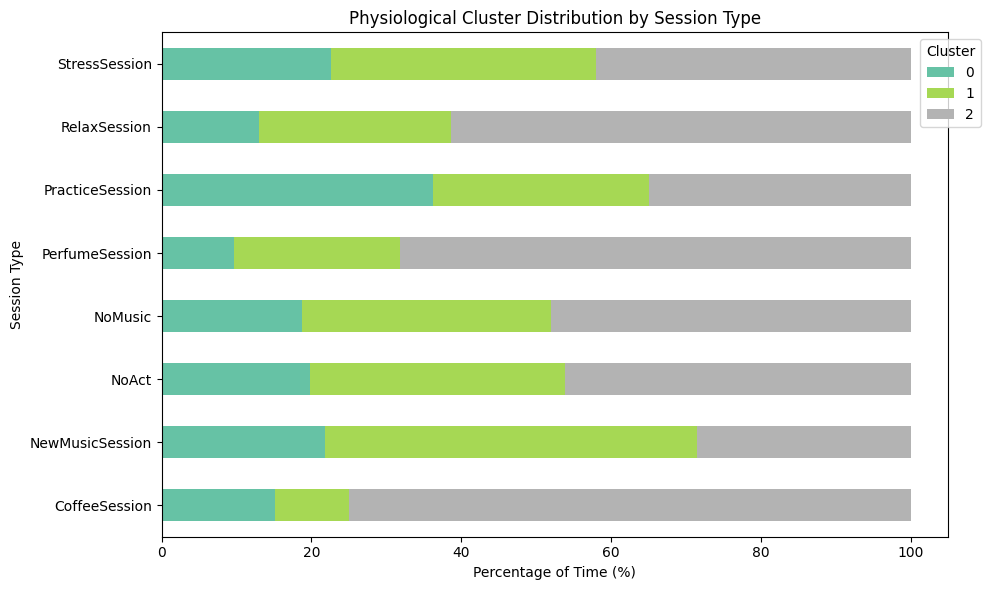

In [33]:
import matplotlib.pyplot as plt

# Prepare pivot table
cluster_pivot = cluster_session_dist.pivot(
    index='session_type',
    columns='physio_cluster',  # or 'physio_state' if labeled
    values='percentage'
)

# Plot horizontal stacked bar
cluster_pivot.plot(
    kind='barh',
    stacked=True,
    figsize=(10,6),
    colormap='Set2'
)

plt.xlabel('Percentage of Time (%)')
plt.ylabel('Session Type')
plt.title('Physiological Cluster Distribution by Session Type')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()



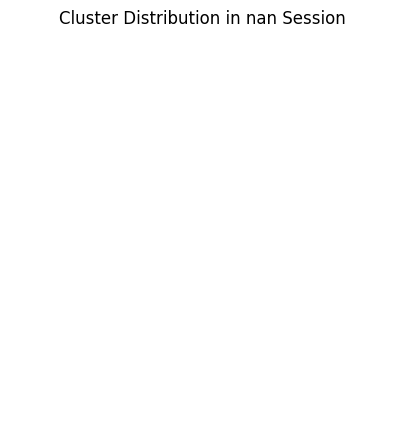

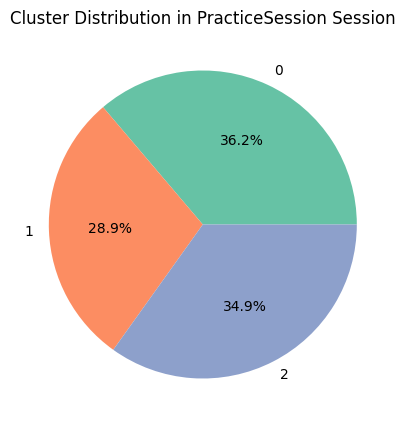

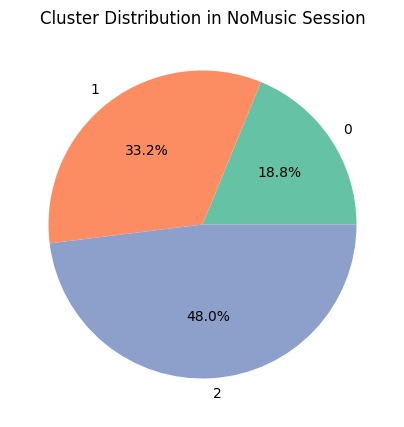

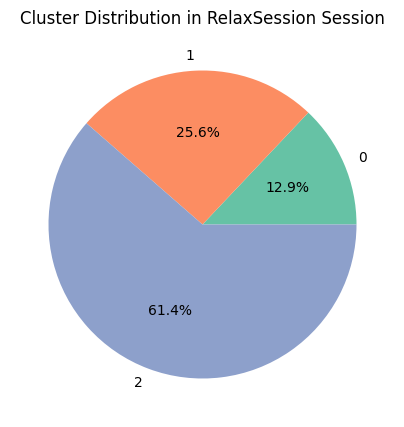

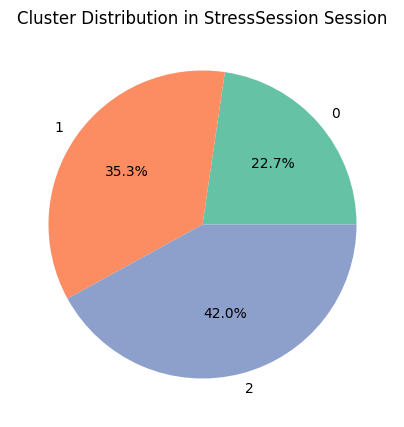

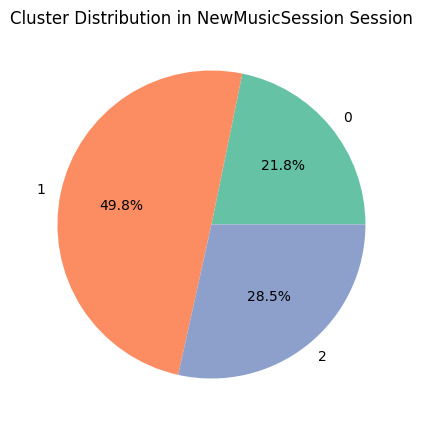

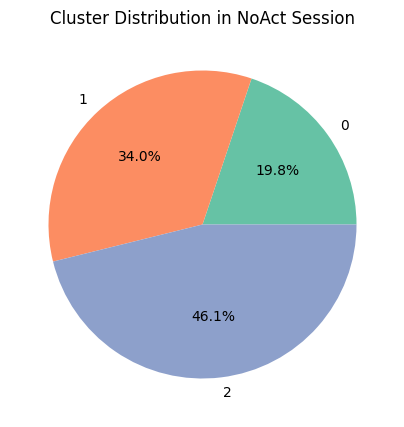

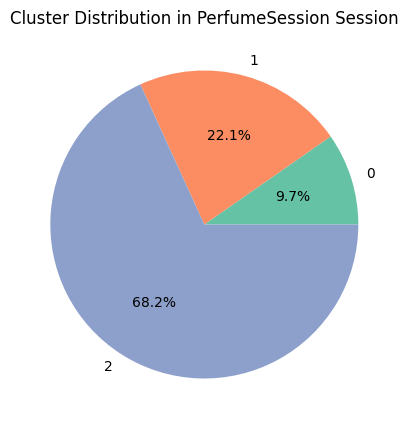

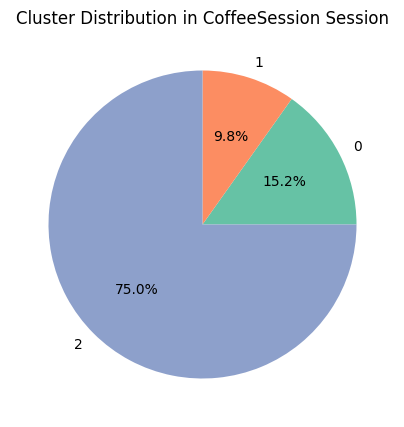

In [34]:
session_types = df_cluster['session_type'].unique()

for session in session_types:
    df_sess = cluster_session_dist[cluster_session_dist['session_type'] == session]
    
    plt.figure(figsize=(5,5))
    plt.pie(
        df_sess['percentage'],
        labels=df_sess['physio_cluster'],  # or 'physio_state'
        autopct='%1.1f%%',
        colors=plt.cm.Set2.colors
    )
    plt.title(f'Cluster Distribution in {session} Session')
    plt.show()


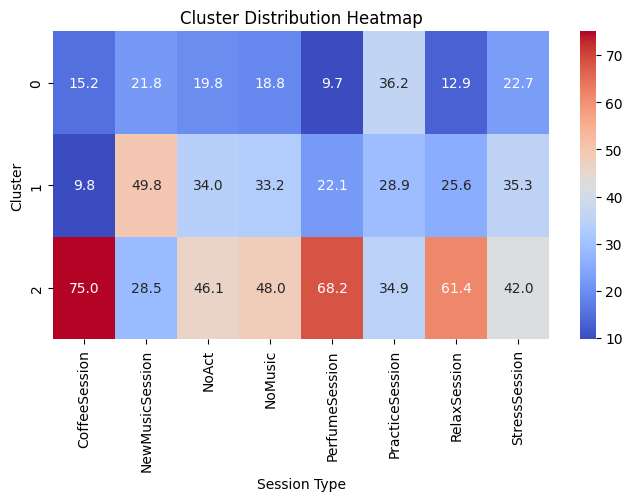

In [35]:
import seaborn as sns

# Pivot for heatmap
heatmap_data = cluster_session_dist.pivot(
    index='physio_cluster',  # or 'physio_state'
    columns='session_type',
    values='percentage'
)

plt.figure(figsize=(8,4))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap='coolwarm'
)
plt.xlabel('Session Type')
plt.ylabel('Cluster')
plt.title('Cluster Distribution Heatmap')
plt.show()


In [36]:
import plotly.graph_objects as go
import plotly.io as pio

# Force browser rendering to avoid nbformat errors
pio.renderers.default = "browser"

# Ensure cluster_session_dist is ready
# Use 'physio_state' if you have physiological labels
clusters = cluster_session_dist['physio_cluster'].unique()
sessions = cluster_session_dist['session_type'].unique()

# Initialize figure
bar_data = []

for cluster in clusters:
    df_cluster_only = cluster_session_dist[cluster_session_dist['physio_cluster'] == cluster]
    bar = go.Bar(
        x=df_cluster_only['session_type'],
        y=df_cluster_only['percentage'],
        name=f'Cluster {cluster}'  # replace with physiological label if available
    )
    bar_data.append(bar)

# Create figure
stacked_bar = go.Figure(data=bar_data)

# Update layout
stacked_bar.update_layout(
    barmode='stack',
    title='Physiological Cluster Distribution by Session Type',
    xaxis_title='Session Type',
    yaxis_title='Percentage of Time (%)',
    legend_title='Cluster',
    template='plotly_white'
)

# Render in browser (avoids Jupyter inline issues)
stacked_bar.show()



Image rendered in browser

![My Image](clustering.png)

I used K-Means clustering because the features are continuous physiological measures, and K-Means efficiently identifies latent groups based on distance in feature space. Additionally, cluster centroids allow post hoc physiological interpretation of each cluster.
Features were z-score normalized per participant to ensure equal weighting in Euclidean space, which aligns with K-Means’ distance-based clustering assumption.

I applied K-Means clustering to wearable-derived physiological features to identify latent physiological states. K-Means was chosen because our data are continuous and normalized, it is computationally efficient, and it produces interpretable centroids for post hoc labeling. Alternative methods such as hierarchical clustering and Gaussian Mixture Models were considered but deemed less suitable due to computational complexity and interpretability. Features were z-score normalized per participant to ensure equal weighting in distance calculations. We selected three clusters (k=3) based on physiological interpretability and silhouette analysis, representing low arousal, high arousal, and movement-related states.

In [37]:
df_cluster.head()

,participant,session_type,window_center,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean,rmssd_mean,physio_cluster,physio_state
0,A1,NaN,1.624262e+09,1.162865,3.165693,-1.767857,-1.702562,-1.526685,0.469326,1.008145,1.039092,0.848142,1.346355,NaN,0,Movement / Artifact
1,A1,NaN,1.624262e+09,1.570601,3.379308,-1.060570,-1.702562,-0.588399,2.201542,1.359436,2.551899,0.833637,1.298917,NaN,0,Movement / Artifact
2,A1,NaN,1.624262e+09,1.237223,3.578404,-1.060570,-0.943631,1.186912,1.806331,1.528118,5.643330,0.804627,1.295268,NaN,0,Movement / Artifact
3,A1,NaN,1.624262e+09,1.052356,4.025681,-1.060570,-1.702562,1.218745,0.237256,0.844082,4.487089,0.786496,1.295268,NaN,0,Movement / Artifact
4,A1,NaN,1.624262e+09,0.834213,4.220630,-1.060570,-1.702562,0.607313,0.233695,-0.333837,1.820404,0.790122,1.284321,NaN,0,Low Arousal


In [38]:
from pathlib import Path

OUT_PATH = Path(r"C:\Users\Kavisha\OneDrive - Johns Hopkins\EN.585.771_BME_DATASCIENCE\Capstone_Project\App\BME_DATA_SCIENCE_CAPSTONE_PROJECT\Data")
OUT_DIR = OUT_PATH / "processed_features_final"
OUT_DIR.mkdir(exist_ok=True, parents=True)
df_cluster.to_csv(OUT_DIR/"all_participants_clusters.csv", index=False)

### Combining the states with the tasks

In [46]:
data_copy = processed_data.copy()

data_copy = processed_data.merge(
    df_cluster[['participant', 'window_center', 'physio_cluster', 'physio_state']],
    on=['participant', 'window_center'],
    how='left'
)


data_copy.head()


,window_start,window_end,window_center,left_eda_mean,left_eda_std,left_eda_n_peaks,right_eda_mean,right_eda_std,right_eda_n_peaks,left_bvp_hr_mean,...,right_ibi_ibi_sdnn,right_ibi_ibi_rmssd,participant,n_events_in_window,mean_RT,prop_correct,session_type,rmssd_mean,physio_cluster,physio_state
0,1.624262e+09,1.624262e+09,1.624262e+09,0.357086,0.110538,0,0.459676,0.108308,1,99.185501,...,NaN,NaN,A1,0,NaN,NaN,NaN,NaN,0,Movement / Artifact
1,1.624262e+09,1.624262e+09,1.624262e+09,0.399479,0.016893,1,0.479464,0.016716,1,156.074040,...,NaN,NaN,A1,0,NaN,NaN,NaN,NaN,0,Movement / Artifact
2,1.624262e+09,1.624262e+09,1.624262e+09,0.364817,0.042236,1,0.497908,0.033514,2,263.711625,...,NaN,NaN,A1,0,NaN,NaN,NaN,NaN,0,Movement / Artifact
3,1.624262e+09,1.624262e+09,1.624262e+09,0.345596,0.038368,1,0.539341,0.020404,1,265.641668,...,NaN,NaN,A1,0,NaN,NaN,NaN,NaN,0,Movement / Artifact
4,1.624262e+09,1.624262e+09,1.624262e+09,0.322915,0.056564,1,0.557400,0.024861,1,228.570394,...,NaN,NaN,A1,0,NaN,NaN,NaN,NaN,0,Low Arousal


In [47]:
# Summary by cluster and session_type
cluster_summary = (
    data_copy
    .groupby(['physio_cluster', 'session_type'])
    .agg(
        n_events=('n_events_in_window', 'sum'),
        mean_RT=('mean_RT', 'mean'),
        prop_correct=('prop_correct', 'mean')
    )
    .reset_index()
)

# Round for readability
cluster_summary = cluster_summary.round(2)
cluster_summary


,physio_cluster,session_type,n_events,mean_RT,prop_correct
0,0,CoffeeSession,7349,0.34,0.42
1,0,NewMusicSession,20910,0.35,0.43
2,0,NoAct,9534,0.38,0.43
3,0,NoMusic,16640,0.37,0.44
4,0,PerfumeSession,3723,0.39,0.45
5,0,PracticeSession,3843,0.42,0.11
6,0,RelaxSession,9564,0.34,0.45
7,0,StressSession,16699,0.36,0.44
8,1,CoffeeSession,7134,0.40,0.44
9,1,NewMusicSession,40101,0.33,0.44


In [41]:
# Summary by threshold state and session_type
state_summary = (
    data_copy
    .groupby(['physio_state', 'session_type'])
    .agg(
        n_events=('n_events_in_window', 'sum'),
        mean_RT=('mean_RT', 'mean'),
        prop_correct=('prop_correct', 'mean')
    )
    .reset_index()
)

# Round for readability
state_summary = state_summary.round(2)
state_summary


,physio_state,session_type,n_events,mean_RT,prop_correct
0,High Arousal,CoffeeSession,2383,0.34,0.39
1,High Arousal,NewMusicSession,6572,0.35,0.43
2,High Arousal,NoAct,4920,0.36,0.45
3,High Arousal,NoMusic,4838,0.35,0.43
4,High Arousal,PerfumeSession,1815,0.31,0.41
5,High Arousal,PracticeSession,1325,0.33,0.08
6,High Arousal,RelaxSession,2897,0.30,0.42
7,High Arousal,StressSession,4104,0.33,0.44
8,Low Arousal,CoffeeSession,49708,0.34,0.43
9,Low Arousal,NewMusicSession,78936,0.34,0.44


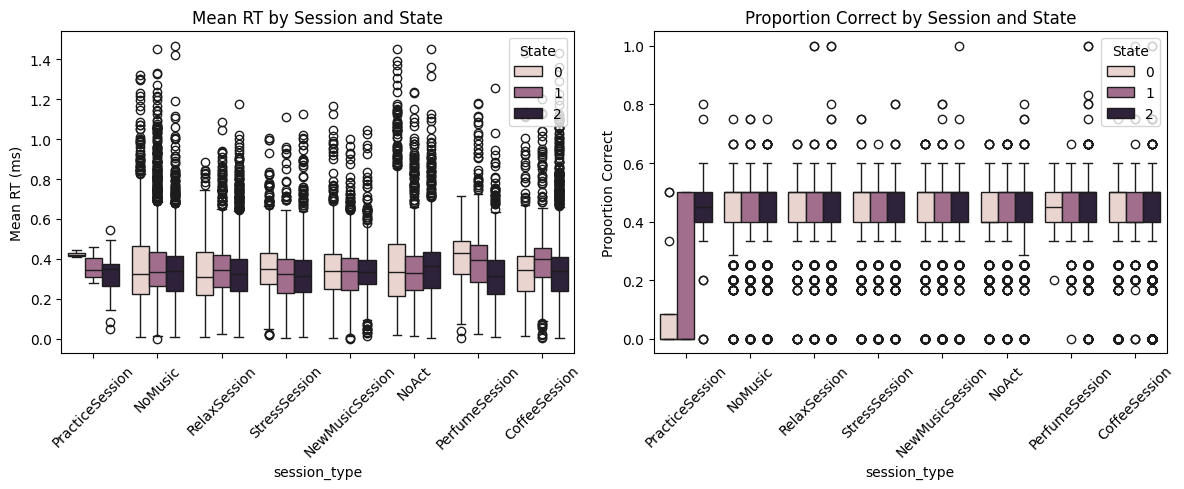

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(12,5))

# ---- Boxplot for mean_RT ----
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.boxplot(
    data=data_copy,
    x='session_type',
    y='mean_RT',
    hue='physio_cluster'
)
plt.title('Mean RT by Session and State')
plt.xticks(rotation=45)
plt.ylabel('Mean RT (ms)')
plt.legend(title='State', loc='upper right')

# ---- Boxplot for prop_correct ----
plt.subplot(1, 2, 2)  # subplot 2
sns.boxplot(
    data=data_copy,
    x='session_type',
    y='prop_correct',
    hue='physio_cluster'
)
plt.title('Proportion Correct by Session and State')
plt.xticks(rotation=45)
plt.ylabel('Proportion Correct')
plt.legend(title='State', loc='upper right')

plt.tight_layout()
plt.show()


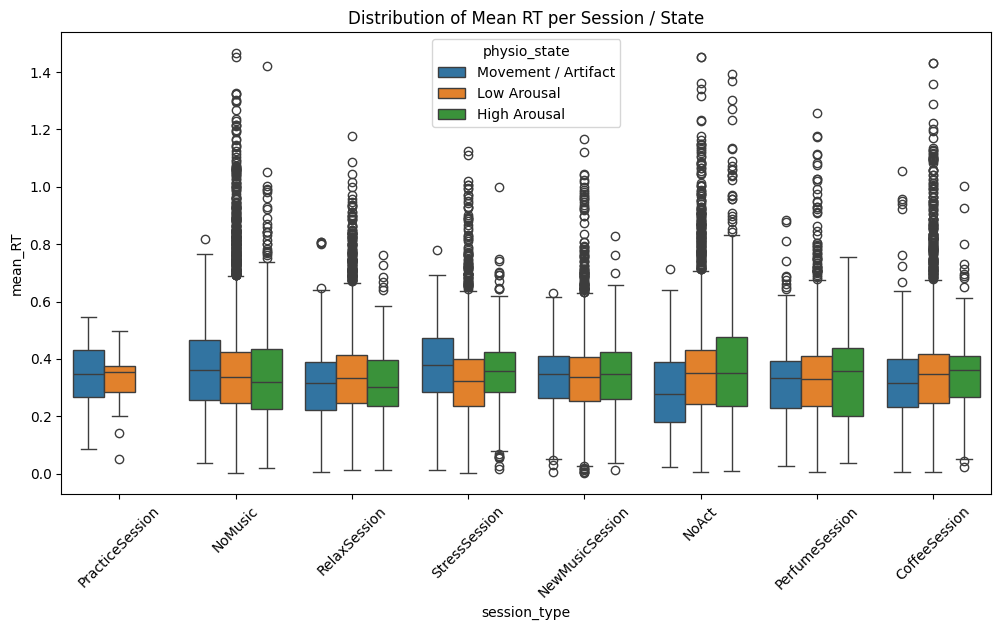

In [49]:
plt.figure(figsize=(12,6))
sns.boxplot(
    data=data_copy,
    x='session_type',
    y='mean_RT',  # change to 'prop_correct' for accuracy
    hue='physio_state'  
)
plt.title('Distribution of Mean RT per Session / State')
plt.xticks(rotation=45)
plt.show()


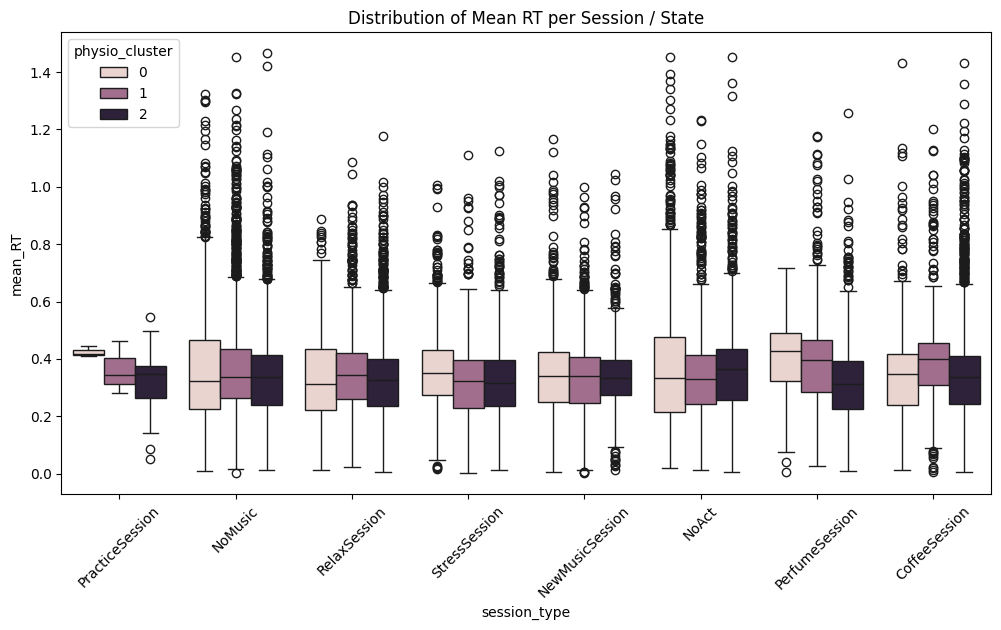

In [50]:
plt.figure(figsize=(12,6))
sns.boxplot(
    data=data_copy,
    x='session_type',
    y='mean_RT',  # change to 'prop_correct' for accuracy
    hue='physio_cluster'  
)
plt.title('Distribution of Mean RT per Session / State')
plt.xticks(rotation=45)
plt.show()


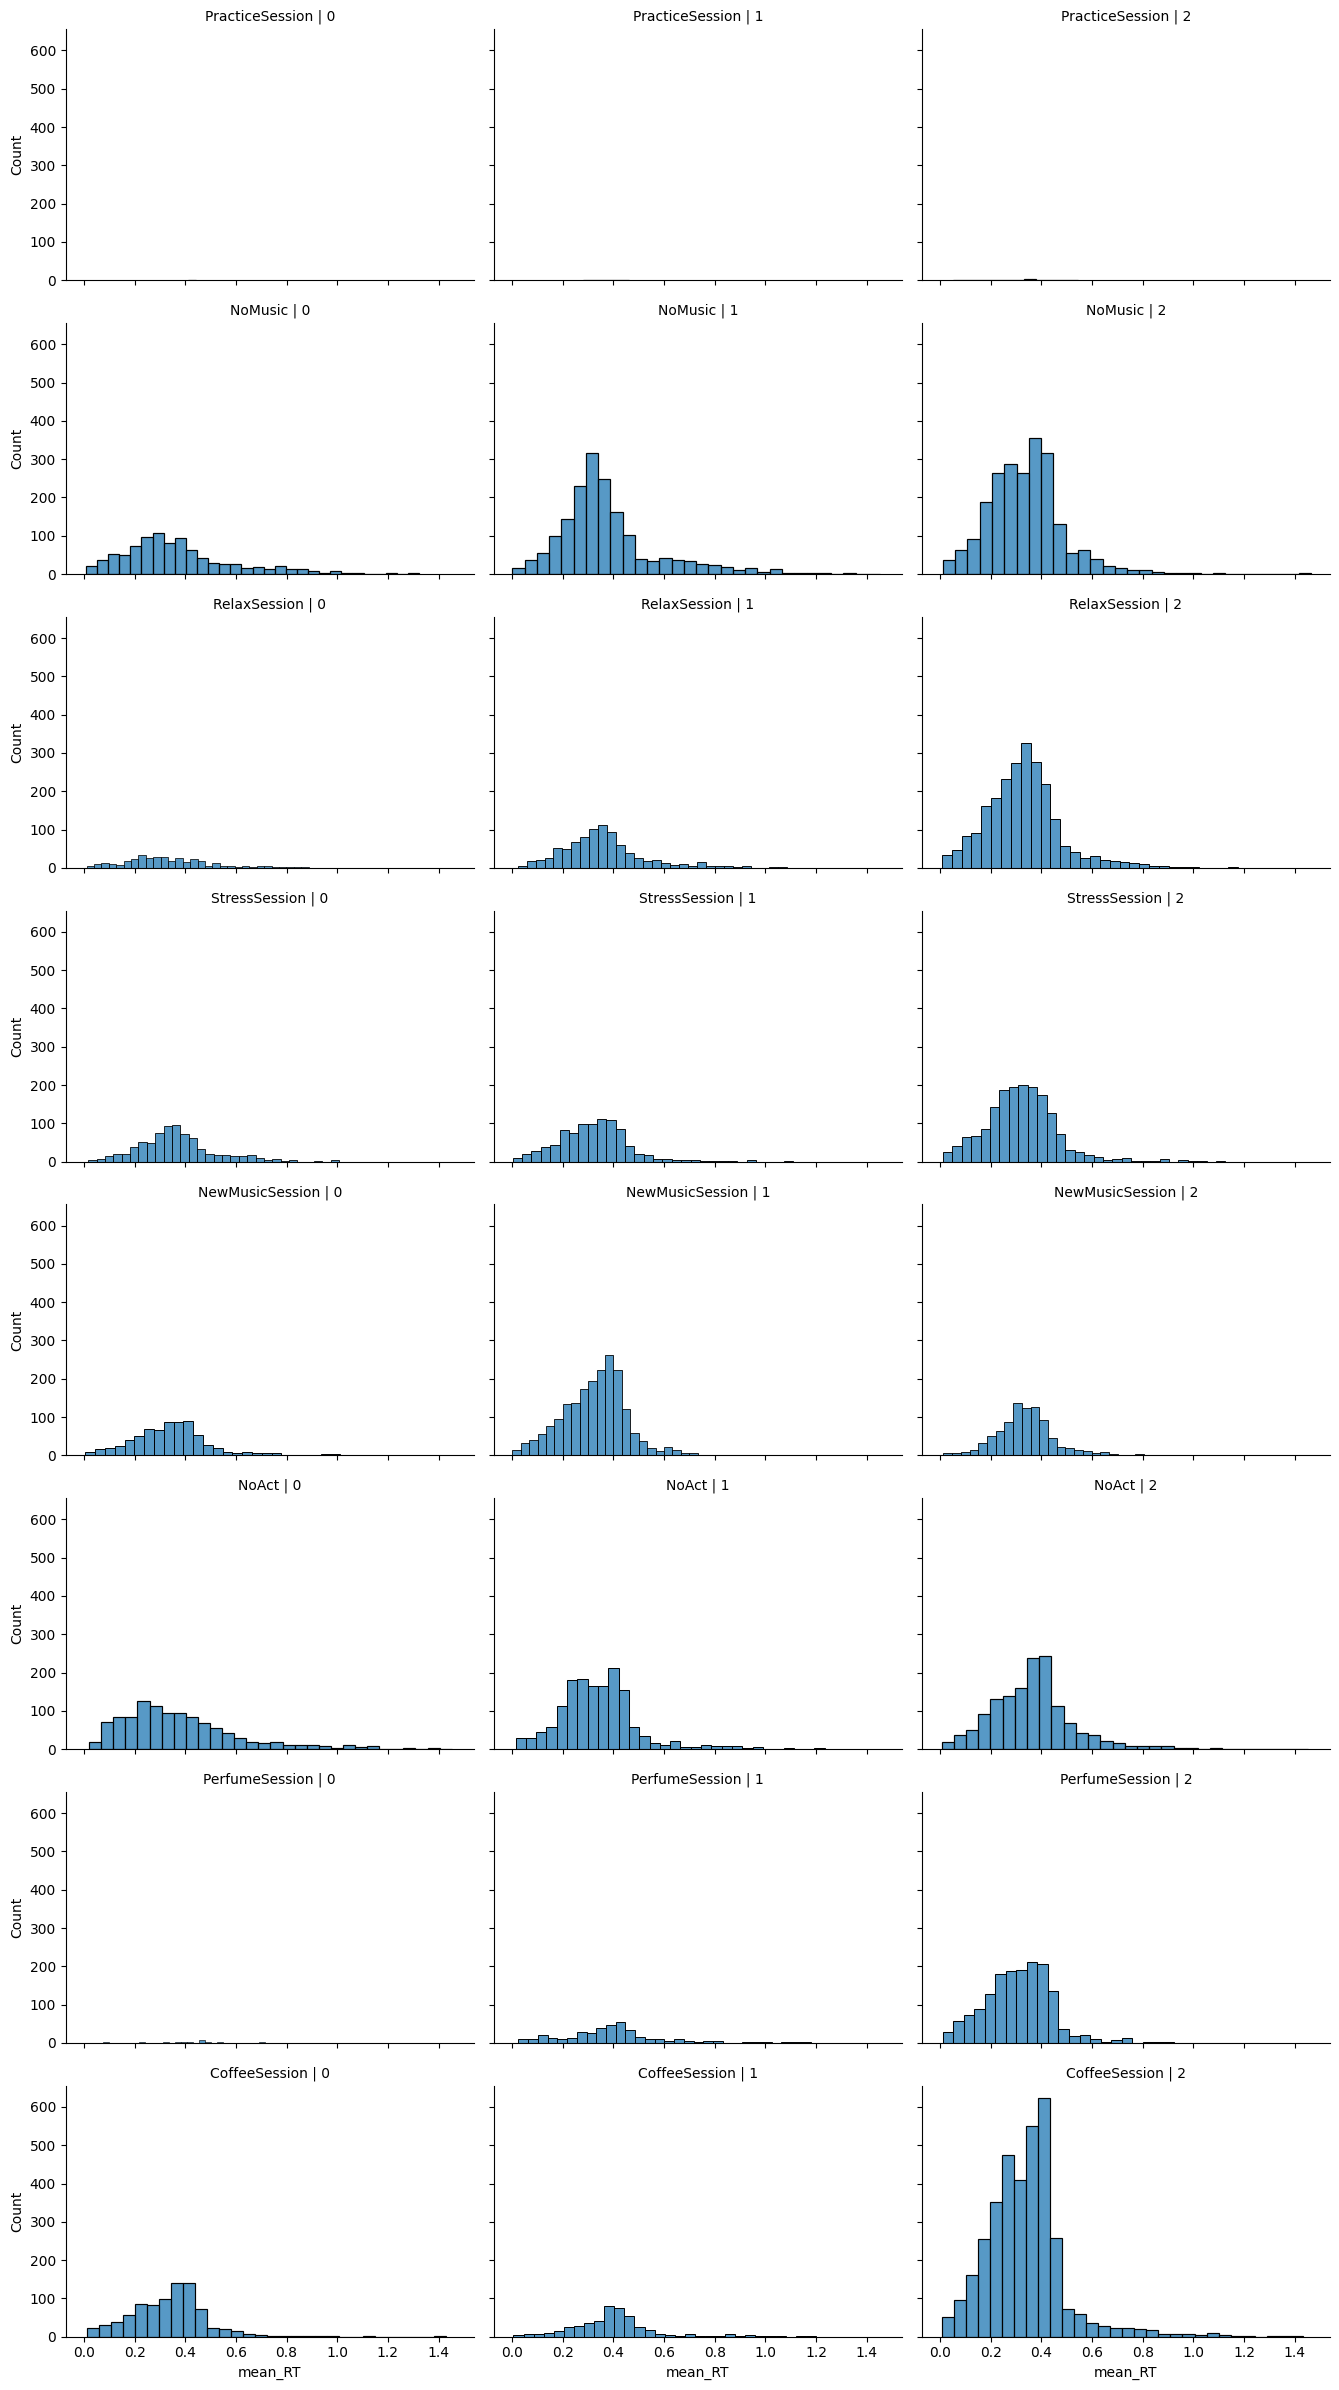

In [51]:
g = sns.FacetGrid(data_copy, col='physio_cluster', row='session_type', height=3, aspect=1.5)
g.map(sns.histplot, 'mean_RT', bins=30)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.show()


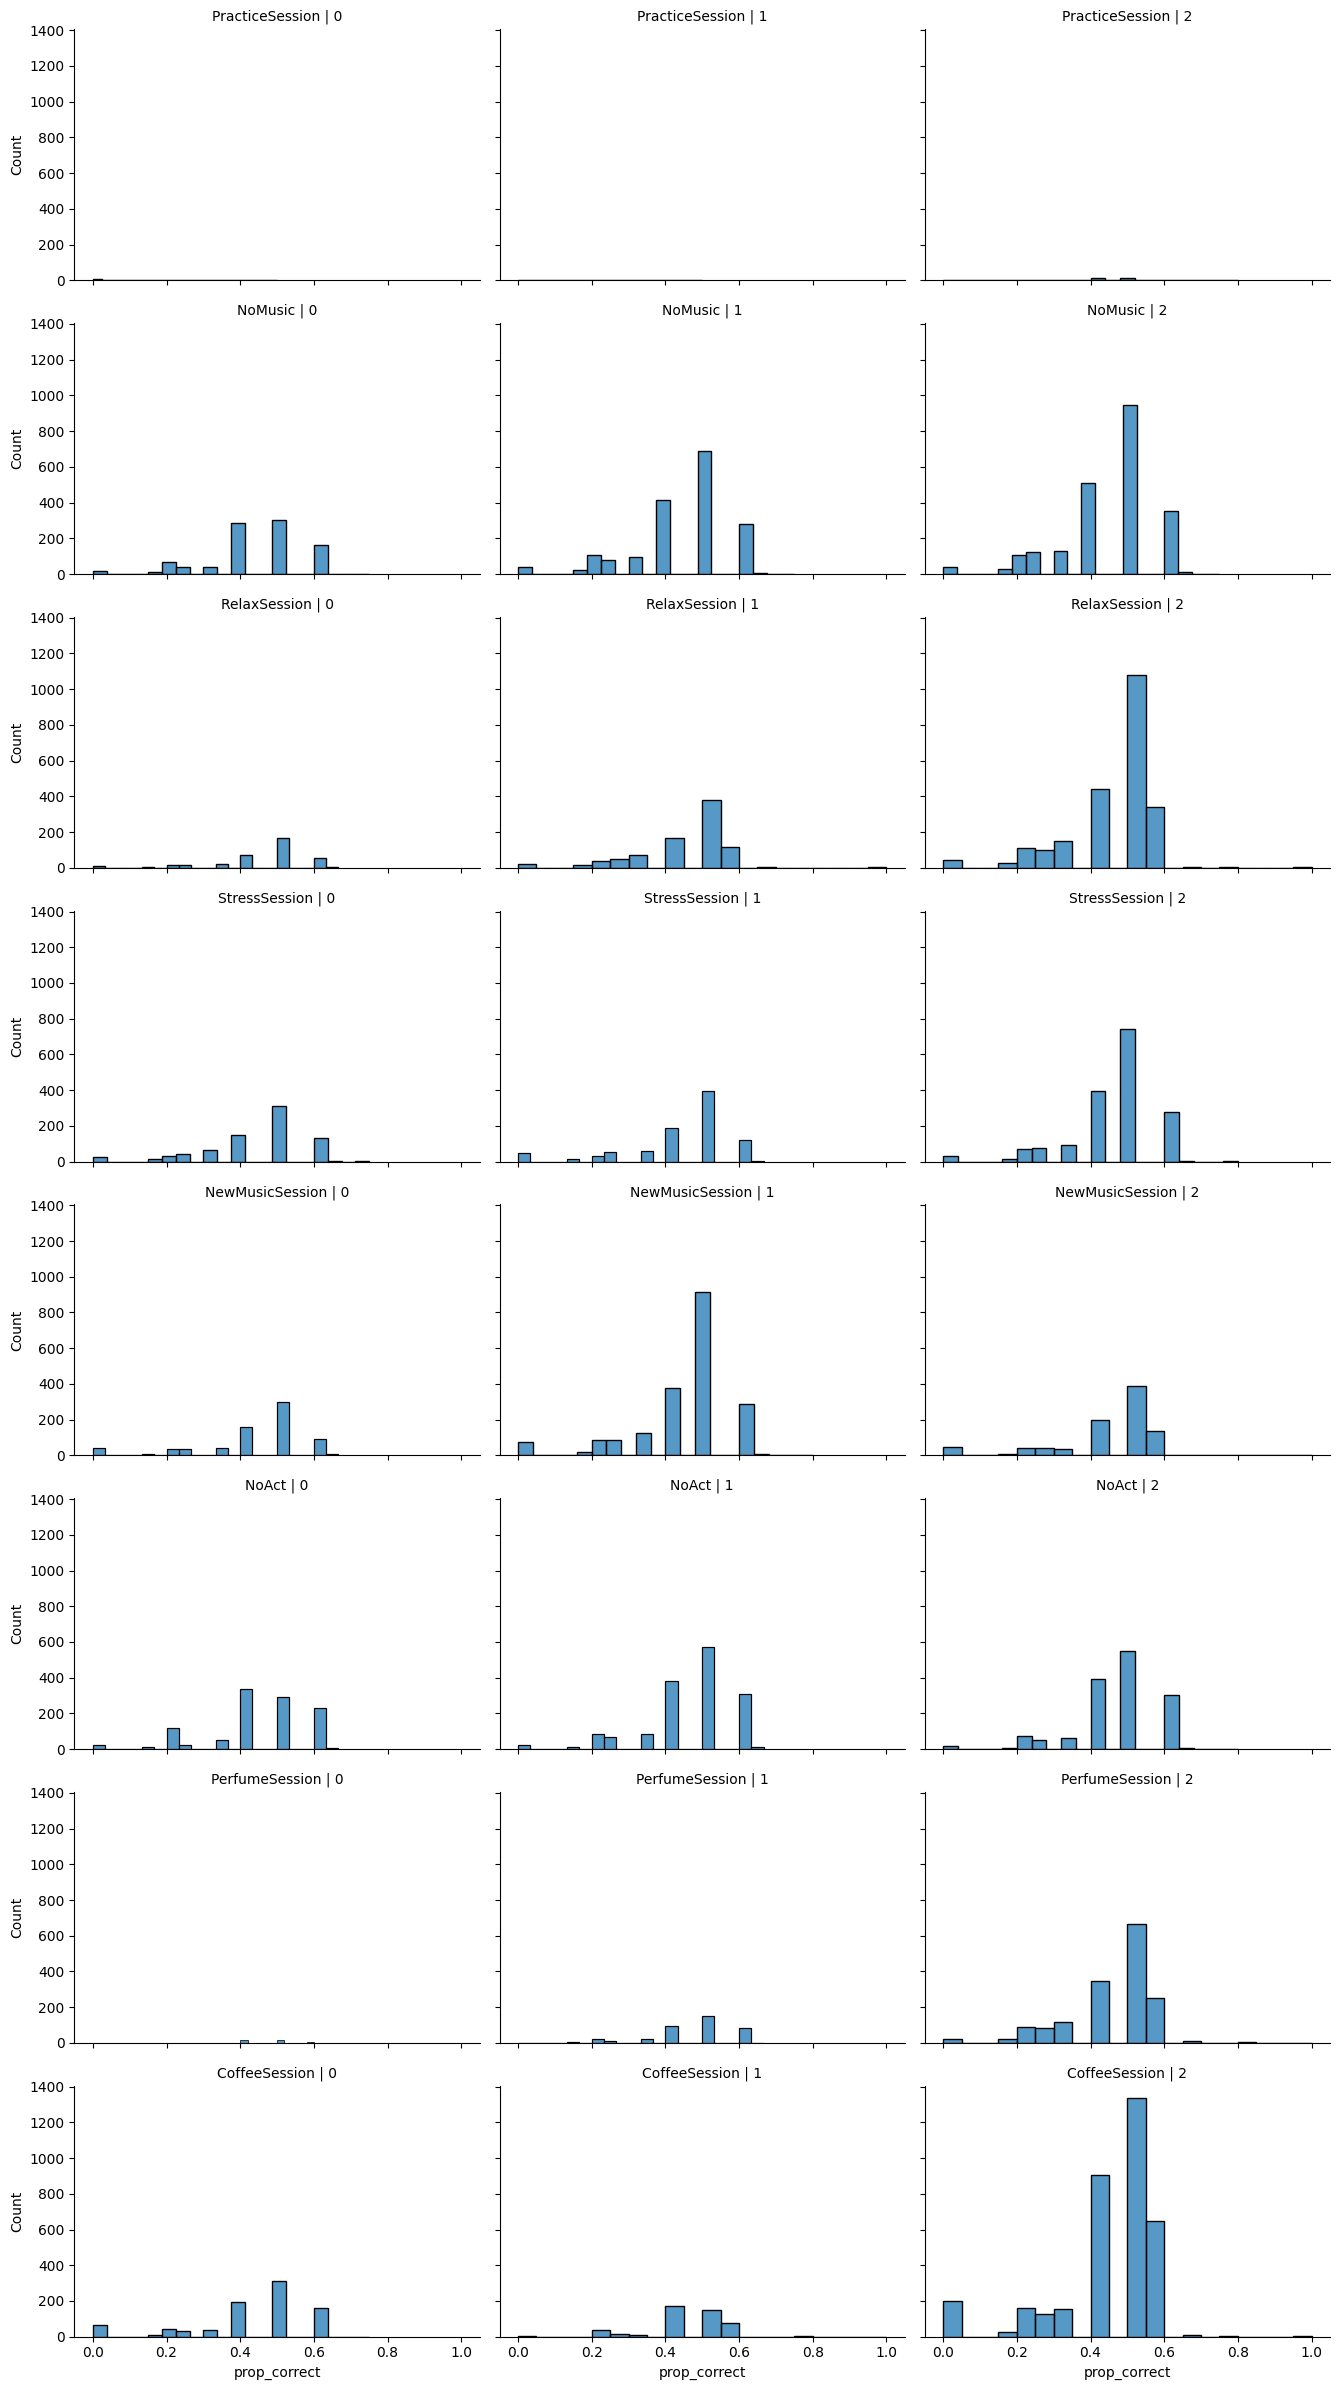

In [55]:
g = sns.FacetGrid(data_copy, col='physio_cluster', row='session_type', height=3, aspect=1.5)
g.map(sns.histplot, 'prop_correct', bins=20)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.show()


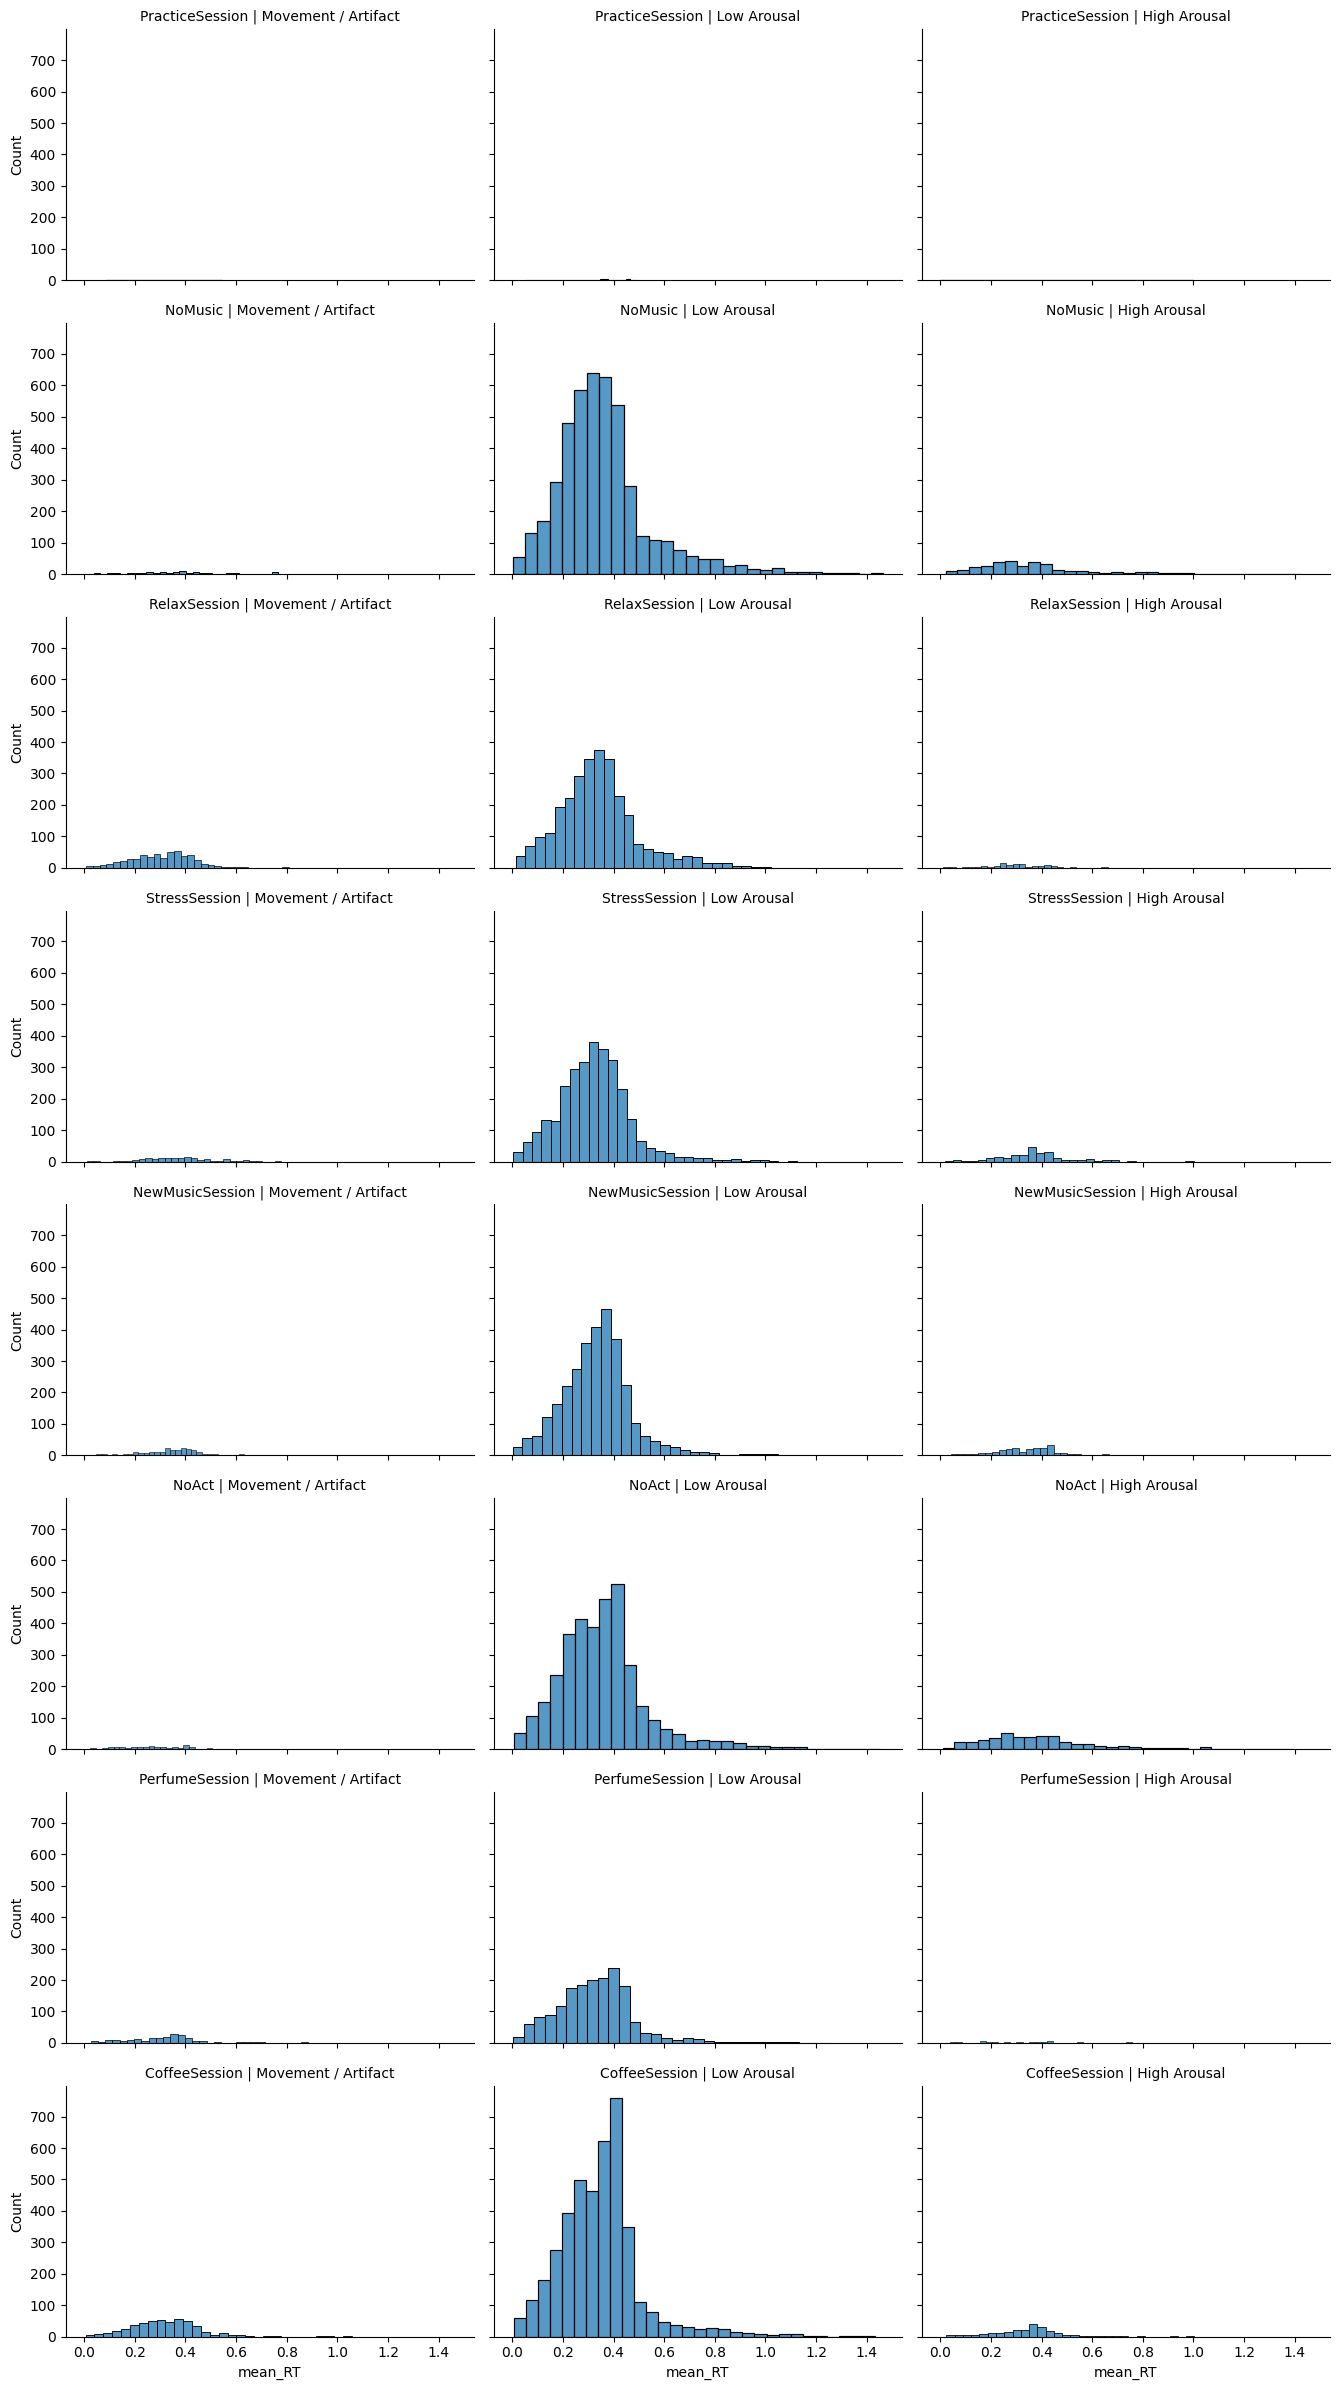

In [52]:
g = sns.FacetGrid(data_copy, col='physio_state', row='session_type', height=3, aspect=1.5)
g.map(sns.histplot, 'mean_RT', bins=30)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.show()

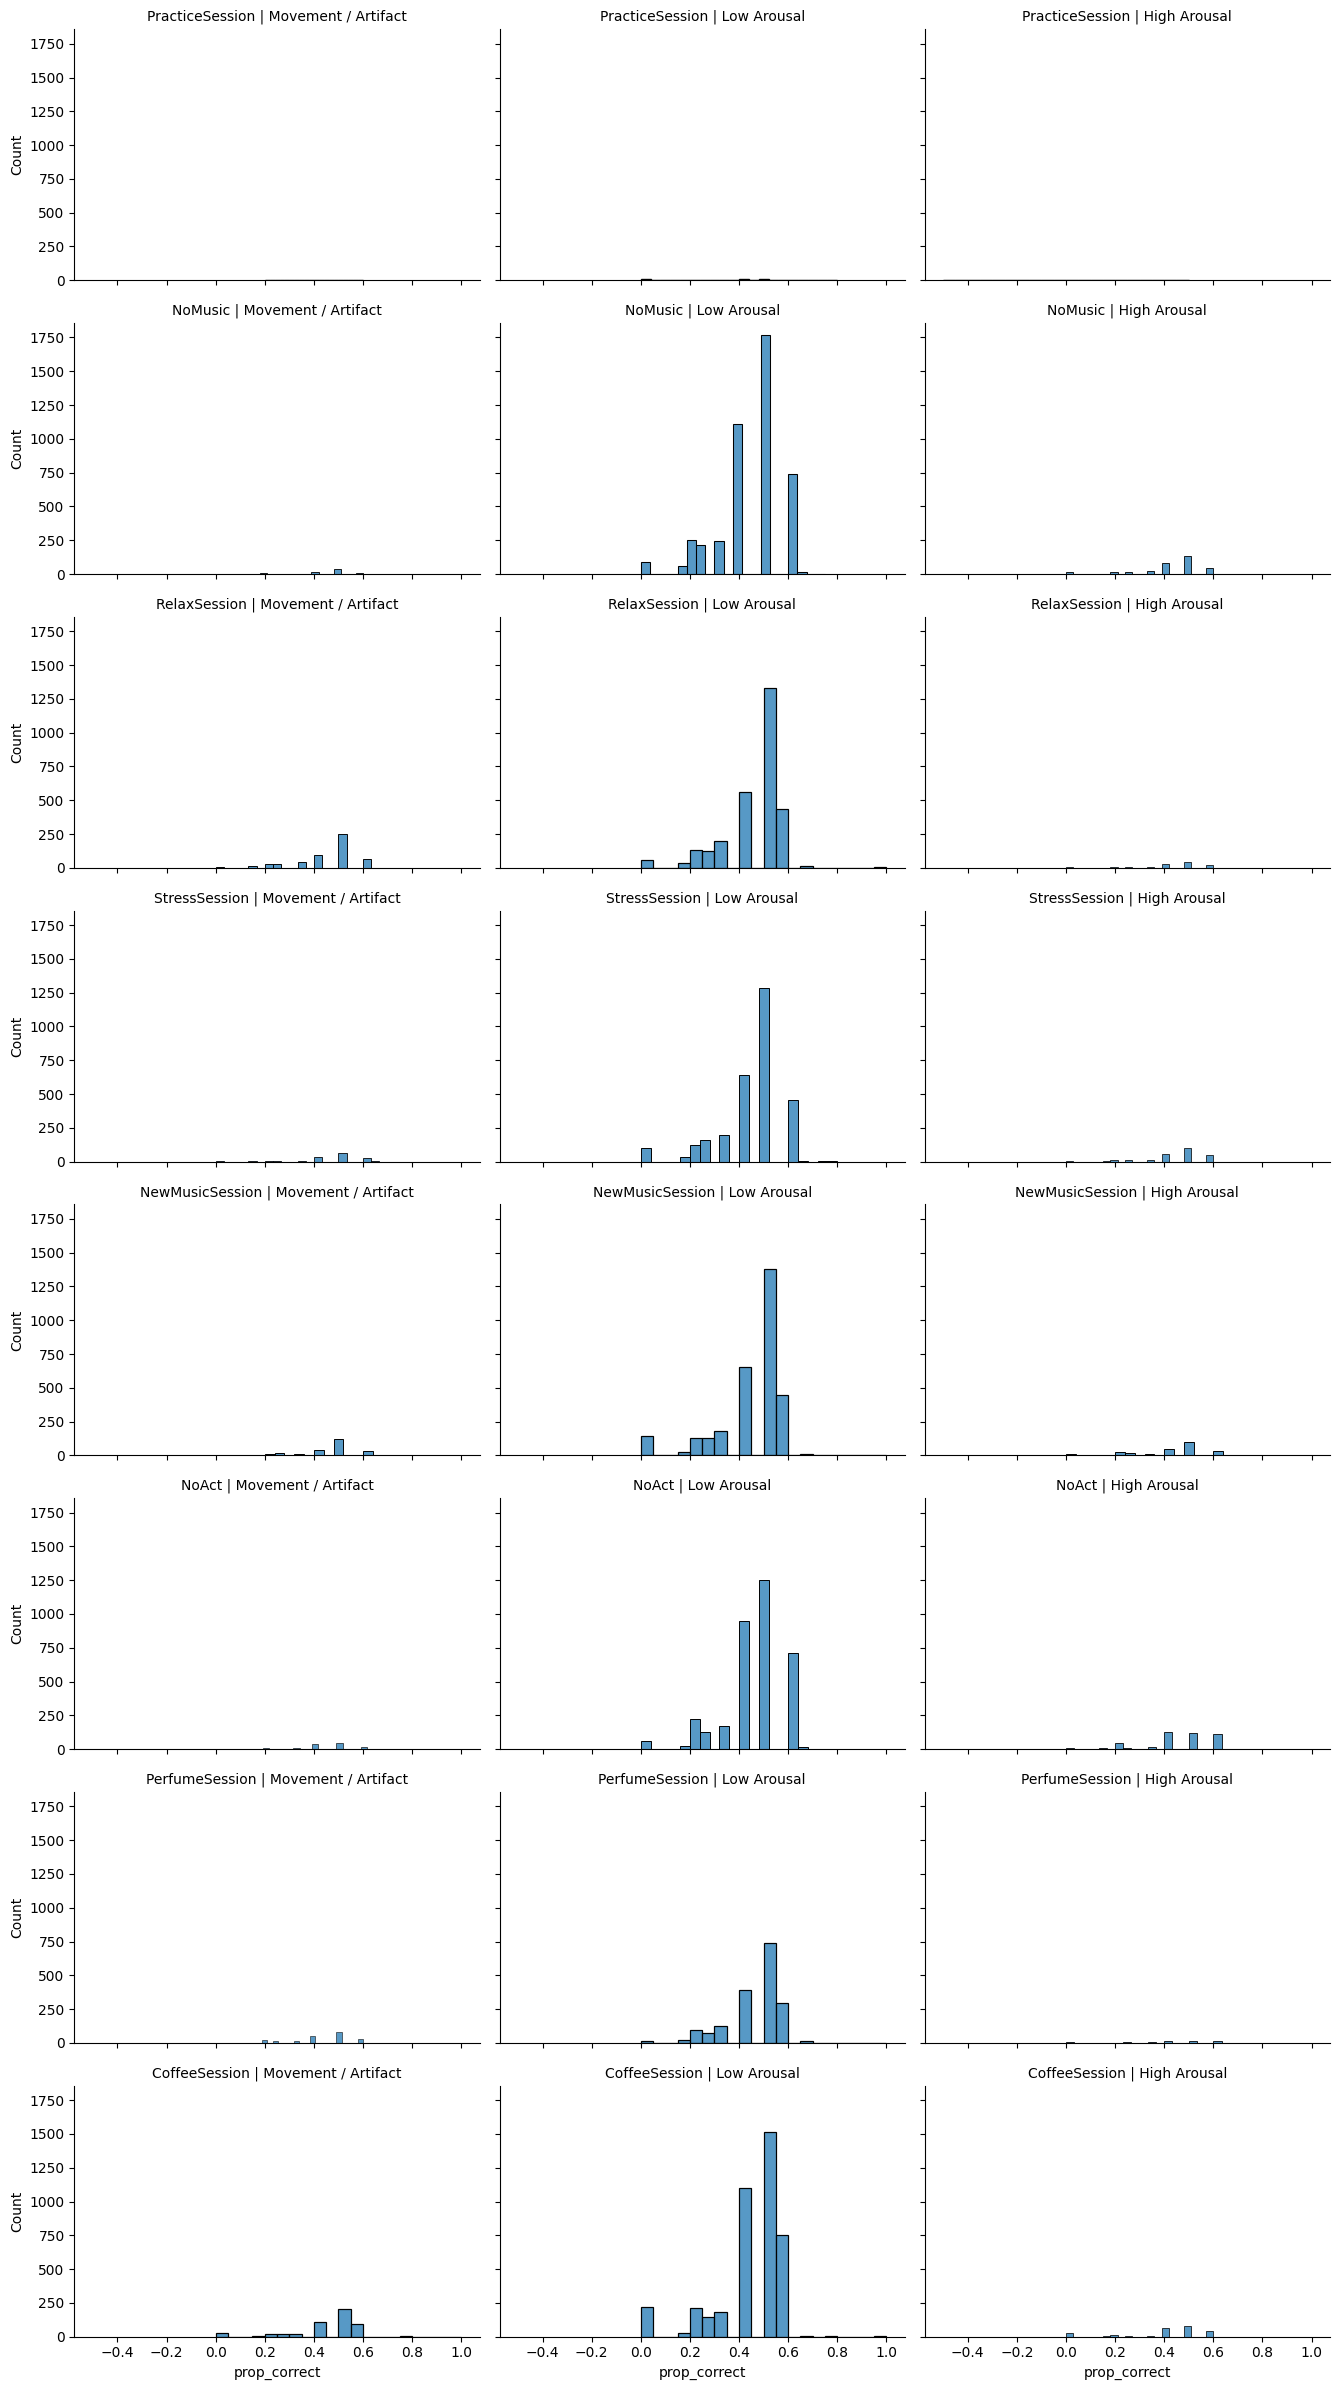

In [56]:
g = sns.FacetGrid(data_copy, col='physio_state', row='session_type', height=3, aspect=1.5)
g.map(sns.histplot, 'prop_correct', bins=20)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.show()